In [24]:
import numpy as np
import matplotlib.pyplot as plt

from blocks_jacobians import firm 

from sequence_jacobian import grids, misc, interpolate
from sequence_jacobian.blocks.support.het_support import lottery_1d
from sequence_jacobian.utilities.solvers import newton_solver

In [25]:
# Variables
K = {'K'}
U = {'U'}
Y = {'A', 'Y', 'r', 'w'}

# Jacobians


# parameters
eis = 1
delta = 0.025
alpha = 0.11
rho_e = 0.966
sd_e = 0.5
r = 0.01
Y = 1
L = 1.0
nE = 7
nA = 500
amin = 0
amax = 200
T = 100
calib = {'eis': eis, 'delta': delta, 'alpha': alpha, 'rho_e': rho_e, 'sd_e': sd_e, 'L': L, 'nE': nE, 'nA': nA, 'amin': amin, 'amax': amax}

In [26]:
# known steady state values
ss = {}
ss['r'] = r
ss['Y'] = Y
ss['L'] = L
ss['w'] = (1 - alpha) * ss['Y'] / ss['L']
ss['K'] = alpha * ss['Y'] / (ss['r'] + delta)
ss['A'] = ss['K']
ss['C'] = ss['Y'] - delta * ss['K']
ss['Z'] = ss['Y'] / (ss['K'] ** alpha * ss['L'] ** (1 - alpha))

print(ss)

{'r': 0.01, 'Y': 1, 'L': 1.0, 'w': 0.89, 'K': 3.142857142857143, 'A': 3.142857142857143, 'C': 0.9214285714285715, 'Z': 0.8816460975214567}


In [27]:
# grids and initial conditions
e_grid, _, Pi = grids.markov_rouwenhorst(rho=rho_e, sigma=sd_e, N=nE)
a_grid = grids.agrid(amin=amin, amax=amax, n=nA)

In [28]:
# analytical Jacobians from firm block
J = firm(calib, ss, T)

In [29]:
# define backward step
def backward_step(Va_p, Pi, a_grid, e_grid, r, w, beta, eis):  # Va_p is t+1 time, so given Va_t+1, solve for Va_t
    uc_nextgrid = beta * (Pi @ Va_p)
    c_nextgrid = uc_nextgrid ** (-eis)
    coh = (1 + r) * a_grid[np.newaxis, :] + w * e_grid[:, np.newaxis]  #coh, cash on hand
    a = interpolate.interpolate_y(c_nextgrid + a_grid, coh, a_grid)
    misc.setmin(a, a_grid[0])
    c = coh - a
    Va = (1 + r) * c ** (-1 / eis) # mariginal value of wealth
    return Va, a, c

# steady state solver
def solve_steady_state_policy(Va0, Pi, a_grid, e_grid, r, w, beta, eis):
    Va = Va0
    for n in range(1000):
        Va, a, c = backward_step(Va, Pi, a_grid, e_grid, r, w, beta, eis)
        if np.max(np.abs(Va - Va0)) < 1e-8:
            print(f'Converged after {n} iterations')
            break
        Va0 = Va
    return Va, a, c

# computes the transition matrix based on policy function for assets
def compute_transition_matrix(a, a_grid, e_grid, Pi):
    nE = e_grid.shape[0]
    nA = a_grid.shape[0]

    # deterministic lottery allocation
    lottery = lottery_1d(a, a_grid, monotonic=False)

    # transition matrix built from lottery
    Lambda = np.zeros((nE, nA, nE, nA))
    for i in range(nE):
        for j in range(nA):
            Lambda[i, j, :, lottery.i[i, j]] = Pi[i, :] * lottery.pi[i, j]
            Lambda[i, j, :, lottery.i[i, j] + 1] = Pi[i, :] * (1 - lottery.pi[i, j])

    # matrix form to compute transition matrix
    Lambda = Lambda.reshape(nA * nE, nA * nE)

    return Lambda

# iterates on the distribution until convergence
def compute_steady_state_distribution(a, a_grid, e_grid, Pi):

    Lambda = compute_transition_matrix(a, a_grid, e_grid, Pi)

    nE = e_grid.shape[0]
    nA = a_grid.shape[0]

    D = np.ones(nE * nA) / (nE * nA)
    for n in range(10000):
        D = Lambda.T @ D
        if np.max(np.abs(D - D @ Lambda)) < 1e-8:
            D = D.reshape(nE, nA)
            print(f'Converged after {n} iterations')
            break
    return D, Lambda


In [30]:
# solve for beta such that asset demand is at steady state
coh = (1 + r) * a_grid[np.newaxis, :] + ss['w'] * e_grid[:, np.newaxis]
Va0 = (1 + r) * (0.1 * coh) ** (-1 / eis)

beta = 0.981
Va, a, c = solve_steady_state_policy(Va0, Pi, a_grid, e_grid, ss['r'], ss['w'], beta, eis)
D, Lambda = compute_steady_state_distribution(a, a_grid, e_grid, Pi)

# find beta that solves the market clearing problem in steady state
def objective(beta):
    Va, a, c = solve_steady_state_policy(Va0, Pi, a_grid, e_grid, ss['r'], ss['w'], beta, eis)
    D, Lambda = compute_steady_state_distribution(a, a_grid, e_grid, Pi)
    A = np.sum(D @ a_grid)
    return np.array([A - ss['A']])

beta, feval = newton_solver(objective, np.array([beta]))

print(beta)

calib['beta'] = beta

Va, a, c = solve_steady_state_policy(Va0, Pi, a_grid, e_grid, ss['r'], ss['w'], calib['beta'], eis)
D, Lambda = compute_steady_state_distribution(a, a_grid, e_grid, Pi)

ss['Va'] = Va
ss['a'] = a
ss['c'] = c
ss['D'] = D
ss['Lambda'] = Lambda

Converged after 361 iterations
Converged after 513 iterations
Converged after 361 iterations
Converged after 513 iterations
On iteration 0
x = 0.981
y = -0.554


Converged after 362 iterations
Converged after 513 iterations
Converged after 391 iterations
Converged after 568 iterations
On iteration 1
x = 0.982
y = 0.080


Converged after 391 iterations
Converged after 569 iterations
Converged after 387 iterations
Converged after 561 iterations
On iteration 2
x = 0.982
y = 0.001


Converged after 388 iterations
Converged after 562 iterations
Converged after 387 iterations
Converged after 561 iterations
On iteration 3
x = 0.982
y = 0.000


Converged after 388 iterations
Converged after 562 iterations
Converged after 387 iterations
Converged after 561 iterations
On iteration 4
x = 0.982
y = 0.000


Converged after 388 iterations
Converged after 562 iterations
Converged after 387 iterations
Converged after 561 iterations
On iteration 5
x = 0.982
y = 0.000


[0.98195277]
Converged after 387 

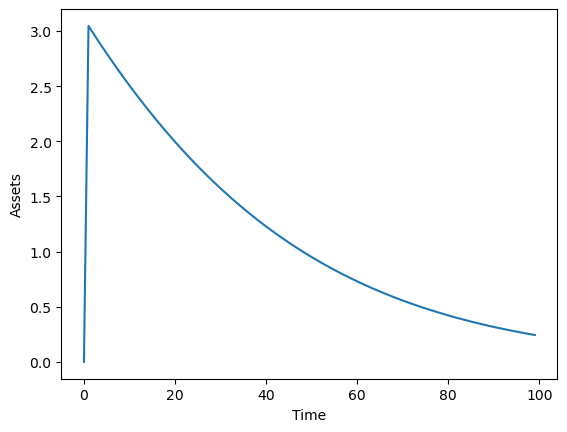

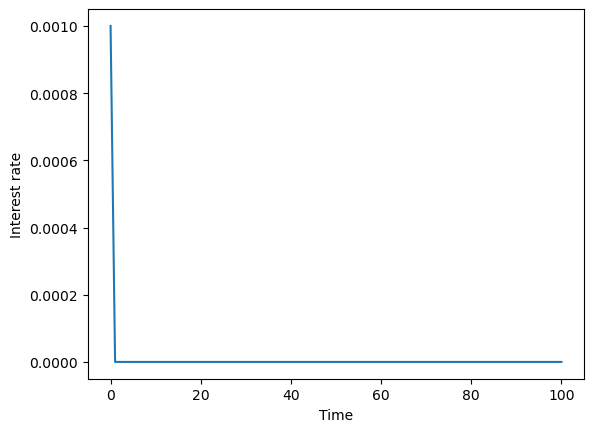

In [34]:
# define r sequence
dx = 1e-3
dA_seq = np.zeros(T,)
dr_seq = np.zeros(T + 1,)
dr_seq[0] = dx

# solve backward step starting at T + 1
Va_p = ss['Va']
a_seq = np.zeros((nE, nA, T + 1))
for t in range(T, -1, -1):
    Va_p, a_seq[:, :, t], c = backward_step(Va_p, Pi, a_grid, e_grid, ss['r'] + dr_seq[t], ss['w'], calib['beta'], eis)


# solve forward step starting at t = 0
D = ss['D']
for t in range(0, T, 1):
    dA_seq[t] = (np.sum(D @ a_grid) - ss['A']) / dx
    Lambda = compute_transition_matrix(a_seq[:, :, t], a_grid, e_grid, Pi)
    D = Lambda.T @ D.reshape(nE * nA,)
    D = D.reshape(nE, nA)

# plor IRF of assets and interest rate
plt.figure()
plt.plot(dA_seq)
plt.xlabel('Time')
plt.ylabel('Assets')
plt.show()

plt.figure()
plt.plot(dr_seq)
plt.xlabel('Time')
plt.ylabel('Interest rate')
plt.show()


In [ ]:
# create fake news matrix
